# Using `spaCy` for text classification

Prior to running this code, it's necessary to install `spaCy` on your machine, and also to download its English libraries. 

Necessary to install `pandas` and `matplotlib` in `virtualenv` first.
```
conda install -c conda-forge matplotlib 
```

*Note:* I'd like to install sklearn in the virtual environment, but `jupyter` is having trouble calling it. I've tried the following to troubleshoot, but so far no dice. Will solve this later.  
* https://stackoverflow.com/questions/42449814/running-jupyter-notebook-in-a-virtualenv-installed-sklearn-module-not-available  

In [1]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spacy.tokens import Doc
from spacy.vocab import Vocab

In [2]:
# Load the pre-defined English model:
# nlp = spacy.load('en')
nlp = spacy.load('en_core_web_md')

### Example using Pandas dataframe

In [3]:
# Read in a CSV file with a column of text abstracts. Keep only the columns we need.
df = pd.read_csv('resources/fedreg_18-05-22-14-45.csv')
df = df[['agency', 'abstract', 'type']]
df['abstract']=df['abstract'].astype(str) # Make sure all values are strings. There were some floats in here.
df = df.dropna(how='any') # get rid of missing data.
df.shape

(2000, 3)

**Note:** In Python 2, it's necessary to convert the text to unicode before tokenizing with `spacy`. In Python 3 this step is not necessary.

In [4]:
# Let's do a little recording, and then take a look at the label column.
df.loc[df['type']=='Proposed Rule', 'type']='Rule'
df=df.loc[df['type']!='Presidential Document']
df['type'].value_counts(dropna=False)

Notice    1537
Rule       430
Name: type, dtype: int64

In [7]:
# Function for train-test split (so I don't have to import sklearn)
def tt_split(df,split=.5):
    train_end=int(len(df)*split)
    train=df[0:train_end]
    test=df[train_end:]
    return train, test

In [8]:
# Split into training and testing data. Keeping it small so the example doesn't take so long.
df_train, df_test=tt_split(df)

In [9]:
# Create a dictionary with the abstract and its labels.
def dictionize_me(row):
    if row['type']=='Rule':
        return (row['abstract'], {"cats": {"Notice": 0, "Rule": 1}})
    else:
        return (row['abstract'], {"cats": {"Notice": 1, "Rule": 0}})

In [12]:
# Apply this function to the pandas dataframe.
df_train['newcol'] = df_train.apply(lambda x: dictionize_me(x), axis=1)
df_train.head(2)

C:\Users\alasseter\AppData\Local\Continuum\anaconda3\envs\spacyenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,agency,abstract,type,newcol
1,Transportation Department,We are superseding Airworthiness Directive (AD...,Rule,(We are superseding Airworthiness Directive (A...
2,Commodity Futures Trading Commission,The Commodity Futures Trading Commission (Comm...,Rule,(The Commodity Futures Trading Commission (Com...


In [13]:
# Convert this into a list
train_data=list(df_train['newcol'])
train_data[0]

('We are superseding Airworthiness Directive (AD) 2017-11-03 for DG Flugzeugbau GmbH Model DG-500MB gliders that are equipped with a Solo 2625 02 engine modified with a fuel injection system following the instructions of Solo Kleinmoteren GmbH Technische Mitteilung 4600-3 and identified as Solo 2625 02i. This AD results from mandatory continuing airworthiness information (MCAI) issued by an aviation authority of another country to identify and correct an unsafe condition on an aviation product. The MCAI describes the unsafe condition as failure of the connecting rod bearing resulting from too much load on the rod bearings from the engine control unit. This AD adds a model to the applicability. We are issuing this AD to require actions to address the unsafe condition on these products.',
 {'cats': {'Notice': 0, 'Rule': 1}})

In [14]:
# Create an analytic "pipeline" of type "textcat"
mytextcat2 = nlp.create_pipe('textcat') # Note that we use 'textcat2' to distinguish from earlier example.
nlp.add_pipe(mytextcat2, last=True)

In [15]:
# Add labels to the pipeline. These will be called using the `.cats` attribute, below.
mytextcat2.add_label('Notice')
mytextcat2.add_label('Rule')

1

In [16]:
# Begin training. 
optimizer = nlp.begin_training()

In [17]:
# Apply to training_data
for x in range(10):
    for doc, gold in train_data:
        nlp.update([doc], [gold], sgd=optimizer)

In [18]:
# Provide a new text, and classify it. The predicted category is called using the `.cats` attribute.
doc = nlp(u'TEST TEST TEST We are TEST superseding TEST Airworthiness Directive (AD) 2017-11-03 for DG TEST Flugzeugbau GmbH Model DG-500MB gliders that are equipped with a Solo 2625 02 engine modified with a fuel injection system following the instructions of Solo Kleinmoteren GmbH Technische Mitteilung 4600-3 and identified as Solo 2625 02i. This AD results from mandatory continuing airworthiness information (MCAI) issued by an aviation authority of another country to identify and correct an unsafe condition on an aviation product. The MCAI describes the unsafe condition as failure of the connecting rod bearing resulting from too much load on the rod bearings from the engine control unit. This AD adds a model to the applicability. TEST TEST TEST We are issuing this AD to require actions to address the unsafe condition on these products. TEST TEST TEST TEST')
print(doc.cats)

{'Notice': 0.005753046832978725, 'Rule': 0.9931173324584961}


In [19]:
# Classify the testing dataset.
def classify_testing_data(row):
    doc = nlp(row['abstract'])
    return (row['abstract'], row['type'], doc.cats['Notice'])

In [20]:
df_test.iloc[0]

agency                                      Energy Department
abstract    In this final action, the Federal Energy Regul...
type                                                     Rule
Name: 999, dtype: object

In [21]:
classify_testing_data(df_test.iloc[0])

('In this final action, the Federal Energy Regulatory Commission (Commission) is amending the pro forma Large Generator Interconnection Procedures and the pro forma Large Generator Interconnection Agreement to improve certainty, promote more informed interconnection, and enhance interconnection processes. The reforms are intended to ensure that the generator interconnection process is just and reasonable and not unduly discriminatory or preferential.',
 'Rule',
 0.025263071060180664)

In [22]:
newdf=df_test.apply(lambda x: classify_testing_data(x), axis=1)

In [23]:
newdf[1902]

('The Commission is updating the competitive product list. This action reflects a publication policy adopted by Commission order. The referenced policy assumes periodic updates. The updates are identified in the body of this document. The competitive product list, which is re-published in its entirety, includes these updates.',
 'Rule',
 0.038809146732091904)

In [24]:
df2 = pd.DataFrame(list(newdf), columns=['abstract', 'type', 'notice_prob'])
df2.head(2)

,abstract,type,notice_prob
0,"In this final action, the Federal Energy Regul...",Rule,0.025263
1,This proposed rule would implement a recommend...,Rule,0.000316


In [25]:
# Create dummy variables.
df2['actual_notice']=df2['type']=='Notice'
df2['pred_notice']=df2['notice_prob']>.5

In [26]:
# Create the confusion matrix variables
df2['conf_matrix']=''
df2.loc[(df2['actual_notice']==True) & (df2['pred_notice']==True),  'conf_matrix']='true_pos'
df2.loc[(df2['actual_notice']==True) & (df2['pred_notice']==False), 'conf_matrix']='false_neg'
df2.loc[(df2['actual_notice']==False) & (df2['pred_notice']==False),  'conf_matrix']='true_neg'
df2.loc[(df2['actual_notice']==False) & (df2['pred_notice']==True),  'conf_matrix']='false_pos'

In [27]:
# How many are actually a "notice"?
df2['actual_notice'].value_counts()

True     776
False    208
Name: actual_notice, dtype: int64

In [28]:
# How many did our model predict as "notice"?
df2['pred_notice'].value_counts()

True     800
False    184
Name: pred_notice, dtype: int64

In [29]:
# Build the conf matrix
df2['conf_matrix'].value_counts()

true_pos     770
true_neg     178
false_pos     30
false_neg      6
Name: conf_matrix, dtype: int64

In [30]:
TP=df2['conf_matrix'].value_counts()[0]
FP=df2['conf_matrix'].value_counts()[1]
FN=df2['conf_matrix'].value_counts()[2]
TN=df2['conf_matrix'].value_counts()[3]
ALL=len(df_test)
print(f'Accuracy: {round((TP + TN)/ALL, 2)}')
print(f'Sensitivity: {round(TP/ (TP + FN), 2)}')
print(f'Precision: {round(TP / (TP + FP), 2)}')
print(f'Specificity: {round(TN / (TN + FP), 2)}')

Accuracy: 0.79
Sensitivity: 0.96
Precision: 0.81
Specificity: 0.03


#### Accuracy:   
Overall, how often is it correct?  
(TP + TN) / total

#### Sensitivity (Recall):
When actual value is positive, how often is prediction correct?   
TP / actual yes   
“True Positive Rate” or “Recall”   

#### Precision:
TP / (TP + FP)

#### Specificity:
When actual value is negative, how often is prediction correct?   
TN / actual no

#### Misclassification Rate (Error Rate):   
Overall, how often is it wrong?   
(FP + FN) / total 

## ROC-AUC Curve

In [76]:
# Calculate the TPRs and FPRs at each threshold:
def roc(probas, true, step=0.01):
    """
    probas should be a numpy array of predict_probas
    true is a pandas series of true labels
    step is the step size for checking thresholds
    """
    
    true = np.array(true)
    assert(len(probas) == len(true)) # We're making sure that our probabilities vector is the same length as our true class labesl vector
    
    TPRs = [] # Setting up empty list of True Positive Rate
    FPRs = [] # Setting up empty list of False Positive Rate
    
    for i in np.arange(0.0,1.0,step): # np.arange allows us to use step sizes that are decimals
        preds_class = probas > i # Numpy arrays have a feature called 'broadcasting.' Check the documentation: https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html to see what this does.
        TP = 0 
        FP = 0
        TN = 0
        FN = 0
        for index in range(len(preds_class)): # We're comparing each prediction with each true value here

            if preds_class[index] == 1 and true[index] == 1:
                TP += 1
            elif preds_class[index] == 1 and true[index] == 0:
                FP += 1
            elif preds_class[index] == 0 and true[index] == 0:
                TN += 1 
            elif preds_class[index] == 0 and true[index] == 1:
                FN += 1
                
        TPR = TP/(TP + FN) # Calculating TPR and FPR and appending to our lists
        FPR = FP/(FP + TN)
        
        TPRs.append(TPR)
        FPRs.append(FPR)
    return (FPRs, TPRs)    

In [77]:
# Display the ROC AUC curve
def auc_curve(FPRs, TPRs):
    plt.rcParams['font.size'] = 14
    plt.plot(FPRs, TPRs, color="orange")
    plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title("Reciever Operating Characteristic")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show();

In [78]:
true=df2['actual_notice'].astype(float)

In [79]:
probas=df2['notice_prob']

In [80]:
# Apply the function
FPRs, TPRs = roc(probas=probas, true=true, step=0.001);

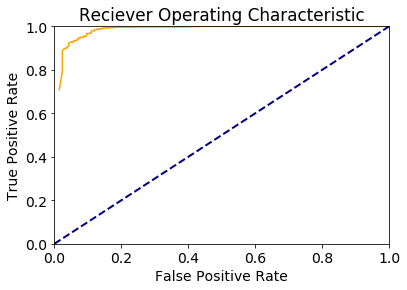

In [81]:
# Display the curve
auc_curve(FPRs, TPRs)

In [103]:
# calculate the roc score:
def auc(y, x):
    auc = 0
    for i in range (1, len(x)):
        auc += ((y[i] + y[i-1])/2)*abs(([x[i]] - x[i-1]))
    return auc[0].astype(float)

In [104]:
# Calculate the ROCAUC score
auc(np.array(TPRs), np.array(FPRs))

0.9761721847739887